# Stats Parallel

Notebook by Cascade Tuholske 2021.02.15 <br>
Trying to speed up 4_Event_Stats.py

In [6]:
#### Dependencies
import pandas as pd
import numpy as np
import xarray as xr
from random import random
from itertools import groupby
from operator import itemgetter
import geopandas as gpd 
import glob
from statistics import mean
import julian
import time 
import multiprocessing as mp 
from multiprocessing import Pool
import os
import sys
import matplotlib.pyplot as plt

In [2]:
# check data
path = '/home/cascade/projects/UrbanHeat/data/processed/PNAS-DATA-v2/'
fns = glob.glob(path+'*')

In [3]:
dfs = []
for fn in fns:
    dfs.append(pd.read_json(fn, orient = 'split'))

In [4]:
fns

['/home/cascade/projects/UrbanHeat/data/processed/PNAS-DATA-v2/HI406_1D_STATS.json',
 '/home/cascade/projects/UrbanHeat/data/processed/PNAS-DATA-v2/WBGT32_1D_STATS.json',
 '/home/cascade/projects/UrbanHeat/data/processed/PNAS-DATA-v2/HI461_1D_STATS.json',
 '/home/cascade/projects/UrbanHeat/data/processed/PNAS-DATA-v2/WBGT28_1D_STATS.json']

In [5]:
for df in dfs: print(len(df))

5734150
3285272
4115942
5821743


In [8]:
dfs[0].head()

,ID_HDC_G0,year,duration,avg_temp,avg_intensity,tot_intensity,event_dates,intensity,tmax,UID
0,8716,1983,1,40.916269,0.316269,0.316269,[1983.04.10],[0.3162688247],[40.9162688247],UID-0
1,8716,1983,2,41.968549,1.368549,2.737099,"[1983.04.23, 1983.04.24]","[2.2036853194, 0.5334132134]","[42.8036853194, 41.1334132134]",UID-1
2,8716,1983,16,47.880512,7.280512,116.488197,"[1983.04.26, 1983.04.27, 1983.04.28, 1983.04.2...","[0.7365281444, 4.1637614766, 9.6917897375, 6.4...","[41.3365281444, 44.7637614766, 50.2917897375, ...",UID-2
3,8716,1983,51,51.438063,10.838063,552.741209,"[1983.05.13, 1983.05.14, 1983.05.15, 1983.05.1...","[3.4425009533, 7.2378939909, 10.2395632742, 9....","[44.0425009533, 47.8378939909, 50.8395632742, ...",UID-3
4,8716,1983,22,53.897499,13.297499,292.544988,"[1983.07.04, 1983.07.05, 1983.07.06, 1983.07.0...","[11.9686002231, 16.3046980407, 14.5550595174, ...","[52.5686002231, 56.9046980407, 55.1550595174, ...",UID-4


Text(0.5, 0, 'days')

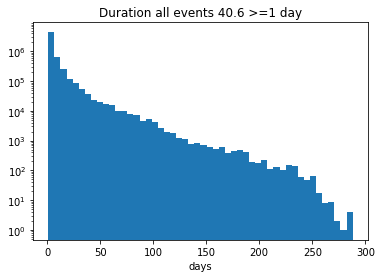

In [29]:
plt.hist(dfs[0]['duration'], bins = 50);
plt.yscale('log')
plt.title('Duration all events 40.6 >=1 day')
plt.xlabel('days')

In [26]:
tmax = dfs[0]['tmax'].to_list()
tmax_lst = [item for sublist in tmax for item in sublist]

Text(0.5, 0, 'HI')

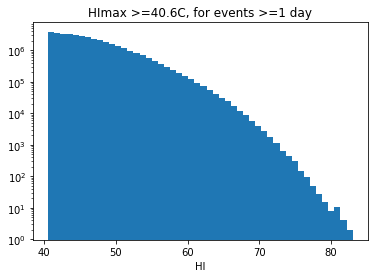

In [30]:
plt.hist(tmax_lst, bins = 50);
plt.yscale('log')
plt.title('HImax >=40.6C, for events >=1 day');
plt.xlabel('HI')

In [32]:
df406 = dfs[0]
df406 = df406[df406['duration'] >= 2]

Text(0.5, 0, 'days')

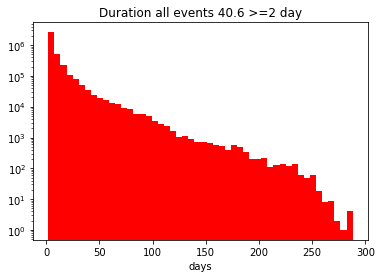

In [33]:
plt.hist(df406['duration'], bins = 50, color = 'red');
plt.yscale('log')
plt.title('Duration all events 40.6 >=2 day')
plt.xlabel('days')

Text(0.5, 0, 'HI')

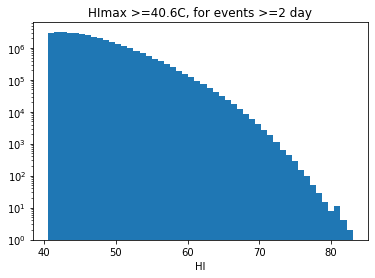

In [34]:
tmax = df406['tmax'].to_list()
tmax_lst = [item for sublist in tmax for item in sublist]

plt.hist(tmax_lst, bins = 50);
plt.yscale('log')
plt.title('HImax >=40.6C, for events >=2 day');
plt.xlabel('HI')

In [2]:
#### Step 1 - Function Loads all Tmax Data as an X-array
def read_data(dir_path, space_dim, time_dim):
    """ Function reads in all Tmax .csv files, joins them by date along the x-axis
    and returns the whole record as a x-array data array
    
    Args:   
        dir_path = path to .csv files 
        time_dim = name for time dim as a str ... use date :-)
        space_dim = col name for GHS-UCDB IDs as an str (ID_HDC_G0)
    """
    fn_list = sorted(glob.glob(dir_path+'*.csv'))
    df_out = pd.DataFrame()
    date_list = []

    # Open all Tmax files and concat into a df
    for i, fn in enumerate(fn_list):    
        # Open the CSV
        df = pd.read_csv(fn)

        # Get the city ids 
        if i == 1:
            df_id = df[space_dim]

        # get only the Tmax columns and concate date list 
        df_temp = df.iloc[:,3:] # get only temp columns
        date_list = date_list+list(df_temp.columns)

        # Drop cities w/ no temp record 
        df_temp_drop = df_temp.dropna()

        # Merge
        df_out = pd.concat([df_out, df_temp_drop], axis=1)
        print(df_out.shape)
    
    # make date into an array
    tmax_arr = df_out.to_numpy()

    # Make data into an xr.DataArray
    tmax_xr_da = xr.DataArray(tmax_arr, coords=[df_id, date_list], 
                             dims=[space_dim, time_dim])
    return tmax_xr_da

In [3]:
#### Step 2 Function finds all the Tmax Events and writes it to a dateframe w/ dates for each city
def tmax_days(xarray, Tthresh):
    """ Function finds all the tmax days in a year and sums total days per year 
    greater than a threshold within a year where Tmax > Tthresh for each city. Returns the total number of days,
    the dates, the tempatures, and the intensity (daily Tmax - Tthresh)
    
    Args: 
        xarray = an xarray object with dims = (space, times)
        Tthresh = int of temp threshold
    """
    
    # empty lists & df
    id_list = []
    date_list = []
    tmax_list = []
    intensity_list = []
    df_out = pd.DataFrame()
    
    # subset xarray
    out = xarray.where(xarray > Tthresh, drop = True)

    # start loop 
    for index, loc in enumerate(out.ID_HDC_G0):
        id_list.append(out.ID_HDC_G0.values[index]) # get IDS
        date_list.append(out.sel(ID_HDC_G0 = loc).dropna(dim = 'date').date.values) # get event dates
        
        # #CPT 2020.02.23 
        # dayTot_list.append(len(out.sel(ID_HDC_G0 = loc).dropna(dim = 'date').date.values)) # get event totals
        
        tmax_list.append(out.sel(ID_HDC_G0 = loc).dropna(dim = 'date').values) # get temp values
        intensity_list.append(out.sel(ID_HDC_G0 = loc).dropna(dim = 'date').values - Tthresh) # get severity

    # write to a data frame
    df_out['ID_HDC_G0'] = id_list
    # df_out['total_days'] = dayTot_list #CPT 2020.02.23
    df_out['dates'] = date_list
    df_out['tmax'] = tmax_list
    df_out['tmax_tntensity'] = intensity_list

    # return df_out
    return df_out


In [4]:
#### Step 3 Function splits the dataset into Tmax events (continuous days >Tmax) for each city
def jul_convert(dates):
    "Function turn days into julian datetime"
    jul_days = pd.to_datetime(dates).to_julian_date()
    
    return jul_days

def event_split(dates, ID_HDC_G0, intensity, tmax): #, total_days): #CPT 2020.02.23
    
    """ Searchs a list of dates and isolates sequential dates as a list, then calculates event stats.
    See comments in code for more details. 
    
    Args:
        dates: pandas.core.index as julian dates
        ID_HDC_G0: city ID as string
        intensity: numpy.ndarray of intensities values
        tmax: numpy.ndarray of intensities values of tmax values
        total_days: total number of tmax days in a year for a given city

    """

    # city id
    city_id = ID_HDC_G0
    # tot_days = total_days #CPT 2020.02.23
    
    # lists to fill
    city_id_list = []
    # tot_days_list = [] #CPT 2020.02.23
    event_dates_list = []
    dur_list = []
    intensity_list = []
    tmax_list = []
    avg_temp_list = []
    avg_int_list = []
    tot_int_list = []
    year_list = []
    
    # data frame out
    df_out = pd.DataFrame()
    
    # turn days into julian days
    jul_days = jul_convert(dates)
    
    # Counters to make sure we write the correct event dates to a list, don't want julian days in output
    counter = 0
    start = 0
    end = 0
    
    # Loop through dur list and isolate seq days, temps, and intensities
    for k, g in groupby(enumerate(jul_days.values), lambda x: x[1]-x[0]):
        
        seq = list(map(itemgetter(1), g)) # isolate seq. days
        dur = len(seq) # duration of each event
        
        counter = counter + dur # add duration to counter
        end = counter # end of current event
        
        event_dates = dates[start:end] # dates of tmax days during each event
        intense = intensity[start:end] # intensity of each day during event
        temp = tmax[start:end] # temp of each day during event
        avg_temp = mean(temp) # avg. temp during event
        avg_int = mean(intense) # avg. intensity during event
        tot_int = np.sum(intense) # total intensity during event 
        
        start = counter # reset start to current end (e.g. counter)
        year = event_dates[0].split('.')[0]
        
        # fill lists
        city_id_list.append(city_id)
        year_list.append(year)
        # tot_days_list.append(tot_days) #CPT 2020.02.23
        dur_list.append(dur)
        event_dates_list.append(event_dates)
        intensity_list.append(intense)
        tmax_list.append(temp)
        avg_temp_list.append(avg_temp)
        avg_int_list.append(avg_int)
        tot_int_list.append(tot_int)

    # write out as a dateframe
    df_out['ID_HDC_G0'] = city_id_list
    df_out['year'] = year_list
    # df_out['total_days'] = tot_days_list #CPT 2020.02.23
    df_out['duration'] = dur_list
    df_out['avg_temp'] = avg_temp_list
    df_out['avg_intensity'] = avg_int_list
    df_out['tot_intensity'] = tot_int_list
    df_out['event_dates'] = event_dates_list
    df_out['duration'] = dur_list
    df_out['intensity'] = intensity_list
    df_out['tmax'] = tmax_list

    return df_out

#### Step 4 function feeds output from function 3 into function 4
def tmax_stats(df_in):
    """ runs event_split functionon a dataframe to produce desired tmax stats

        NOTE - If you add arguments to event_split to make more states,
        be sure to update this function

        args:
            df: input dataframe
    """
    df_out = pd.DataFrame()

    # NOTE - If you add arguments to event_split to make more stats,
    # be sure to update this function

    for index, row in df_in.iterrows():
        dates = row['dates'] # Get event dates
        intensity = row['tmax_tntensity'] # Get intensity for each day
        tmax = row['tmax'] # Get tmax for each day
        ID_HDC_G0 = row['ID_HDC_G0'] # get city id
        # total_days = row['total_days'] # get total number of tmax days -- CPT 2020.02.23

        df = event_split(dates, ID_HDC_G0, intensity, tmax)# , total_days) #CPT 2020.02.23

        df_out = df_out.append(df)

    return df_out

#### Step 5 function threads it all together
def run_stats(dir_path, space_dim, time_dim, Tthresh, fn_out):
    
    """ Function ties all the Tmax Stats functions together and writes final stats for each Tmax 
    event to a .csv file. Returns results as a dataframe if needed
    
    Args:
        dir_path = path to .csv files 
        time_dim = name for time dim as a str ... use date :-)
        space_dim = col name for GHS-UCDB IDs as an str (ID_HDC_G0)
        Tthresh = float of temp threshold
        fn_out = file and path to write final csv
        
    """
    
    # read in data
    step1= read_data(dir_path, space_dim = space_dim, time_dim = time_dim)
    #step1_sub = step1[:,:10] # subset data for testing
    print('Stack x-array made')
    
    # Mask data based on Tmax threshold ... we're using 40.6C
    step2 = tmax_days(step1, Tthresh)
    print('Tmax masked')
    
    
    # Calculate stats
    step3 = tmax_stats(step2)
    print('Stats made')

    # Save file out
    step3.to_json(fn_out, orient = 'split')
    
    return step3

    print('done')

In [5]:
## Arges Needed 
DATA_IN = '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/HI/' # output from avg temp
DATA_OUT = '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/'
dir_path = DATA_IN 
space_dim = 'ID_HDC_G0'
time_dim = 'date'
Tthresh = 40.6
fn_out = DATA_OUT+'STATS_1DAY406.json'

In [6]:
# read in data
step1 = read_data(dir_path, space_dim = space_dim, time_dim = time_dim)

(13067, 365)
(13067, 731)
(13067, 1096)
(13067, 1461)
(13067, 1826)
(13067, 2192)
(13067, 2557)
(13067, 2922)
(13067, 3287)
(13067, 3653)
(13067, 4018)
(13067, 4383)
(13067, 4748)
(13067, 5114)
(13067, 5479)
(13067, 5844)
(13067, 6209)
(13067, 6575)
(13067, 6940)
(13067, 7305)
(13067, 7670)
(13067, 8036)
(13067, 8401)
(13067, 8766)
(13067, 9131)
(13067, 9497)
(13067, 9862)
(13067, 10227)
(13067, 10592)
(13067, 10958)
(13067, 11323)
(13067, 11688)
(13067, 12053)
(13067, 12419)


In [7]:
# Mask data based on Tmax threshold ... we're using 40.6C
step2 = tmax_days(step1, Tthresh)
print('Tmax masked')

Tmax masked


In [20]:
step2.head()

,ID_HDC_G0,dates,tmax,tmax_tntensity
0,3554,[2010.07.29],[42.91095336309989],[2.310953363099891]
1,3295,[2010.07.29],[42.365039604142964],[1.765039604142963]
2,3242,[2010.07.29],[40.941567828562654],[0.34156782856265266]
3,9075,"[1988.07.22, 1988.07.23, 1988.07.24, 1988.07.2...","[42.60064411402778, 44.46700911035864, 44.7843...","[2.0006441140277786, 3.8670091103586373, 4.184..."
4,4362,"[1989.07.19, 1990.07.10, 1996.07.13, 2001.07.2...","[40.77021376234568, 42.44143213521773, 41.0918...","[0.17021376234568208, 1.8414321352177296, 0.49..."


In [26]:
# this is how to split the df

len(np.array_split(step2, 3)[2])

3887

In [35]:
fn_list = glob.glob(DATA_OUT+'HI406_tmp/*STAT*')
fn_list[0]

'/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/HI406_tmp/HI406_STAT_9.json'

In [40]:
df_list = []
for fn in fn_list:
    df_list.append(pd.read_json(fn, orient = 'split'))

df_out = pd.concat(df_list)
df_out.to_json(fn_out, orient = 'split')

In [41]:
df_out

,ID_HDC_G0,year,duration,avg_temp,avg_intensity,tot_intensity,event_dates,intensity,tmax
0,8716,1983,1,40.916269,0.316269,0.316269,[1983.04.10],[0.3162688247],[40.9162688247]
1,8716,1983,2,41.968549,1.368549,2.737099,"[1983.04.23, 1983.04.24]","[2.2036853194, 0.5334132134]","[42.8036853194, 41.1334132134]"
2,8716,1983,16,47.880512,7.280512,116.488197,"[1983.04.26, 1983.04.27, 1983.04.28, 1983.04.2...","[0.7365281444, 4.1637614766, 9.6917897375, 6.4...","[41.3365281444, 44.7637614766, 50.2917897375, ..."
3,8716,1983,51,51.438063,10.838063,552.741209,"[1983.05.13, 1983.05.14, 1983.05.15, 1983.05.1...","[3.4425009533, 7.2378939909, 10.2395632742, 9....","[44.0425009533, 47.8378939909, 50.8395632742, ..."
4,8716,1983,22,53.897499,13.297499,292.544988,"[1983.07.04, 1983.07.05, 1983.07.06, 1983.07.0...","[11.9686002231, 16.3046980407, 14.5550595174, ...","[52.5686002231, 56.9046980407, 55.1550595174, ..."
...,...,...,...,...,...,...,...,...,...
739,7913,2016,3,44.063638,3.463638,10.390913,"[2016.09.27, 2016.09.28, 2016.09.29]","[3.7426933615999998, 3.8692065932, 2.7790127486]","[44.3426933616, 44.4692065932, 43.3790127486]"
740,7913,2016,4,42.075934,1.475934,5.903736,"[2016.10.01, 2016.10.02, 2016.10.03, 2016.10.04]","[2.425792107, 0.2698984881, 0.8358455298, 2.37...","[43.025792107, 40.8698984881, 41.4358455298, 4..."
741,7913,2016,2,41.662540,1.062540,2.125080,"[2016.10.06, 2016.10.07]","[0.7375403857, 1.3875400703]","[41.3375403857, 41.9875400703]"
742,7913,2016,5,44.139456,3.539456,17.697282,"[2016.10.09, 2016.10.10, 2016.10.11, 2016.10.1...","[1.69968388, 6.5772558792, 5.4375574898, 3.022...","[42.29968388, 47.1772558792, 46.0375574898, 43..."


In [42]:
done = pd.read_json(DATA_OUT+'HI406_STATS.json', orient = 'split')

# Is the data the same?
cpt feb 2021

In [89]:
new = pd.read_json('/home/cascade/projects/UrbanHeat/data/processed/PNAS-DATA-v2/HI406_STATS.json', orient = 'split')

In [90]:
old = pd.read_csv('/home/cascade/projects/UrbanHeat/data/processed/PNAS-DATA-v1/AllDATA-GHS-ERA5-HI406.csv')

In [91]:
new.shape

(5734150, 10)

In [92]:
old.shape

(5746476, 13)

In [93]:
old[(old['ID_HDC_G0'] == 3091) & (old['year'] == 1983)]

,Unnamed: 0,ID_HDC_G0,CTR_MN_NM,total_days,duration,avg_temp,avg_intensity,tot_intensity,event_dates,intensity,tmax,year,Event_ID
0,0,3091,Poland,1,1,42.493549,1.893549,1.893549,['1983.05.16'],[1.89354862],[42.49354862],1983,1


In [94]:
new[(new['ID_HDC_G0'] == 3091) & (new['year'] == 1983)]

,ID_HDC_G0,year,duration,avg_temp,avg_intensity,tot_intensity,event_dates,intensity,tmax,UID
0,3091,1983,1,42.493549,1.893549,1.893549,[1983.05.16],[1.8935486155999999],[42.4935486156],UID-2340963


# Old Code

In [17]:
cpu = 20+2 # - 2
n = int(len(step2)/ cpu)  #chunk row size
list_df = [step2 [i:i+n] for i in range(0,step2.shape[0],n)]
print(len(list_df))

23


In [15]:
len(step2)

11661

In [16]:
step2

,ID_HDC_G0,dates,tmax,tmax_tntensity
0,3554,[2010.07.29],[42.91095336309989],[2.310953363099891]
1,3295,[2010.07.29],[42.365039604142964],[1.765039604142963]
2,3242,[2010.07.29],[40.941567828562654],[0.34156782856265266]
3,9075,"[1988.07.22, 1988.07.23, 1988.07.24, 1988.07.2...","[42.60064411402778, 44.46700911035864, 44.7843...","[2.0006441140277786, 3.8670091103586373, 4.184..."
4,4362,"[1989.07.19, 1990.07.10, 1996.07.13, 2001.07.2...","[40.77021376234568, 42.44143213521773, 41.0918...","[0.17021376234568208, 1.8414321352177296, 0.49..."
...,...,...,...,...
11656,968,[2013.01.20],[42.02921292854994],[1.429212928549937]
11657,1087,"[1983.01.01, 1983.01.05, 1983.01.12, 1983.01.2...","[42.1275297653516, 41.70304743074981, 46.36813...","[1.527529765351602, 1.103047430749811, 5.76813..."
11658,1081,"[1983.01.05, 1983.02.04, 1983.02.05, 1983.11.2...","[40.94428549255453, 40.62568825715032, 41.7781...","[0.34428549255452623, 0.025688257150321192, 1...."
11659,12943,"[1991.01.03, 1994.01.26, 1997.01.21, 2001.02.0...","[48.04558470377348, 41.501496488217626, 43.111...","[7.445584703773477, 0.9014964882176244, 2.5114..."


In [10]:
# write them out
for i, df in enumerate(list_df):
    df.to_json(DATA_OUT+'tmp/tmp_'+str(i)+'.json', orient = 'split')

In [ ]:
#os.mkdir(DATA_OUT+'temp')

In [11]:
fns_list = glob.glob(DATA_OUT+'tmp/*.json')

In [12]:
fns_list

['/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_0.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_4.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_16.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_8.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_12.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_17.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_9.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_13.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_1.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_5.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/tmp_15.json',
 '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/tmp/

In [ ]:
fn = fns_list[0]
df = pd.read_json(fn, orient = 'split')

In [ ]:
step3 = tmax_stats(df)

In [ ]:
def max_stats_run(fn):
    
    """ runs max_stats on a fn (.json) and writes on .json)
    Args:
        fn = file name
    """
    
    # open df
    df = pd.read_json(fn, orient = 'split')
    i = fn.split('temp_')[1].split('.json')[0]
    
    # make small for testing 
    df = df.iloc[0:4,:]
    
    # Calculate stats
    step3 = max_stats(df)

    # write file
    fn_out = DATA_OUT+'temp/'+'STAT_'+str(i)+'.json'
    step3.to_json(fn_out, orient = 'split')
    print('done', i)



In [ ]:
for fn in fns_list:
    tbd(fn)

In [ ]:
test = glob.glob(DATA_OUT+'temp/STAT*')

In [ ]:
test

In [ ]:
import Event_Stats_Funcs

In [ ]:
test = '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/HI406_temp/HI406_2.json'

In [ ]:
data = test.split('_temp/')[1].split('_')[0]
i = test.split(data+'_temp/')[1].split(data+'_')[1]
DATA_OUT = test.split(data+'_temp')[0]

In [ ]:
DATA_OUT

In [ ]:
glob.glob('/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/HI406_temp/*')

In [ ]:
fn = '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/STATS/HI406_temp/HI406_STAT_6.json'
test = pd.read_json(fn, orient = 'split')
test.head()